# Uncertainty Quantification for test cases

In [1]:
import os
import shutil

import numpy as np
from scipy.stats import norm,uniform,multivariate_normal

import UQLib.calibration.TMCMC as TMCMC
import test_cases.sinusoidal as sinusoidal
import test_cases.cosine as cosine

import matplotlib.pyplot as plt

#np.random.seed(1234)

## Inverse UQ for a cosine function

### Sample from Posterior using TMCMC algorithm

In [2]:
modelpath = "/home/kevin/master_project/IUQ-Project/test_cases/cosine.py"

# Generate data with Gaussian noise
x, y, y_err, true_params = cosine.generate(16,scale=0.01)
a, c, k, f = true_params

# Parameter names
model_params = ["k","f"]
error_params = ["s"]
design_vars = ["x","a","c"]

print("True parameter values:")
print(tuple(model_params), "=")
print((k,f))

# Design variable values
design_vals = np.row_stack(np.broadcast(x,a,c))
#design_vals = x

# Error parameter per design point
model_errors = ["s" for n in range(x.shape[0])]

# Define uniform prior wrapper functions and samplers for the model parameters
model_func = lambda val: uniform.pdf(val,-5.0,10.0)
model_sampler = lambda n_samples: np.random.uniform(-5.0,5.0,size=n_samples)

# Define prior wrapper function and sampler for the error parameter
error_func = lambda val: uniform.pdf(val,0.001,0.999)
error_sampler = lambda n_samples: np.random.uniform(0.001,1.0,size=n_samples)

model_priors = [(model_func,model_sampler) for param in model_params]
error_priors = [(error_func,error_sampler)]

# Construct problem dict
problem = {"setup":cosine.setup,
           "measure":cosine.read_output,
           "modelpath":modelpath,
           "model parameters":model_params,
           "error parameters":error_params,
           "design variables":design_vars,
           "input data":design_vals,
           "output data":y,
           "data errors":y_err,
           "error mapping":model_errors,
           "model priors":model_priors,
           "error priors":error_priors
          }

os.makedirs("TMCMC_output")
os.chdir("TMCMC_output")

df,qoi = TMCMC.sample(problem,100,nprocs=8)

os.chdir("..")

# Remove garbage
shutil.rmtree("./TMCMC_output")

print(df)

True parameter values:
('k', 'f') =
(3.914770487626013, 1.3846959044058131)
Calculate next p
p: 1e-06
COV: 3.9780543639888655
Running stage 1...
Current max likelihood: 9.674623905414353e-19
Calculate next p
p: 0.004138039532667573
COV: 0.9999998070672412
Running stage 2...
Current max likelihood: 9.674623905414353e-19
Calculate next p
p: 0.010849888915379347
COV: 0.9999989940056068
Running stage 3...
Current max likelihood: 2.3708321278620772e-15
Calculate next p
p: 0.06504666825930641
COV: 1.0000001256145479
Running stage 4...
Current max likelihood: 1.601028398040253e-14
Calculate next p
p: 0.19601971602875962
COV: 0.9999996416161588
Running stage 5...
Current max likelihood: 1.601028398040253e-14
Calculate next p
p: 0.3760494690815722
COV: 1.0000002881867527
Running stage 6...
Current max likelihood: 1.680862174585566e-14
Calculate next p
p: 1.0
COV: 0.9271516307599741
Running stage 7...
Current max likelihood: 1.7122686253183882e-14
           k         f         s    likelihood
0

### Propagate uncertainty forward to output

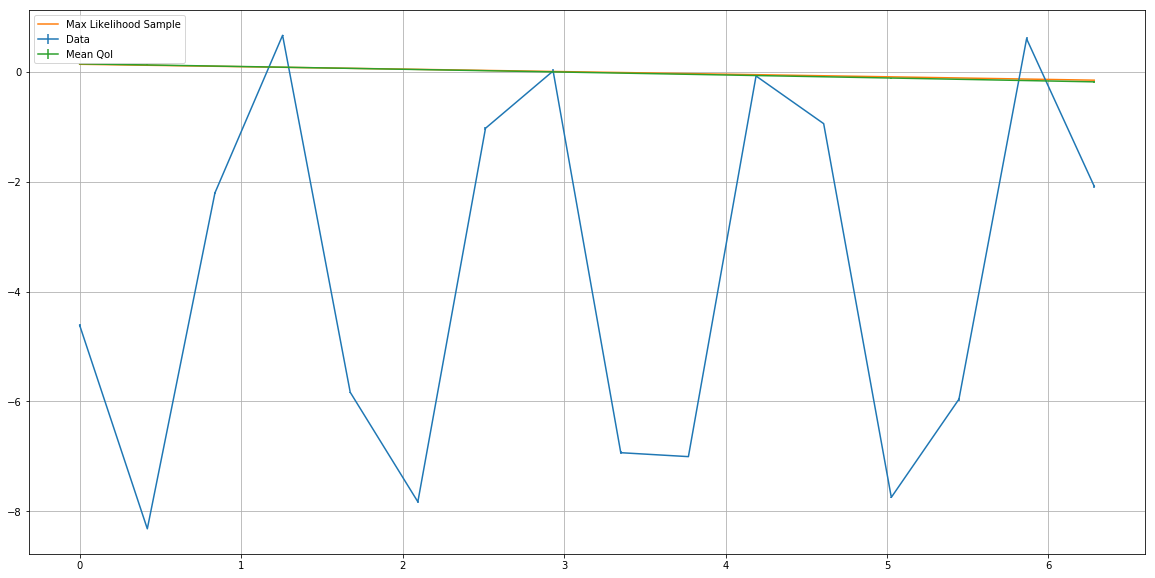

In [3]:
a,c,k,f = true_params

plt.figure(figsize=(20,10))
plt.grid(True)

# Data
plt.errorbar(x,y,yerr=y_err,label="Data")

# True values
interval = np.linspace(0,2*np.pi,100)
#plt.plot(interval,cosine.evaluate(interval,a,c,k,f),label="True distribution")

# Highest likelihood
mle = np.argmax(df["likelihood"].values)
plt.plot(x,qoi[mle],label="Max Likelihood Sample")

# All distributions
#for n in range(qoi.shape[0]):
#    plt.plot(x,qoi[n])

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

plt.errorbar(x,mean,yerr=conf,label="Mean QoI")

plt.legend()

plt.show()

### Sanity check for output parity

In [4]:
for n in range(qoi.shape[0]):
    k,f = df.values[n,:2]
    remeasure_qoi = cosine.evaluate(x,a,c,k,f)
    if (qoi[n] != remeasure_qoi).any():
        print("Difference:",qoi[n]-remeasure_qoi[n])